# OpenPose Keypoint Analysis of a Single Pitch from Multiple Angles

### By: Jake Bell

## Setup:
Openpose automatically organizes all the single-frame .JSON keypoint files in one folder when you process a video.

Store all the individual .JSON keypoint folders from each video in one big folder.

Place this program in the same directory as the one storing the .JSON keypoint folders

## How to Run the Program:
When prompted, fill out the appropriate information for each video file.
The needed variables are:
- json_folder_name 
    * The name of the folder containing all the video output folders
- width_of_subject_area
    * The measurement of how wide the camera’s field of vision is
- camera_pixel_width
    * The measurement of how many pixels wide the video is
- camera_pixel_height
    * The measurement of how many pixels tall the video is
- camera_fps
    * The measurement of how many frames per second the video was filmed at
- is_right_handed
    * This variable specifies which arm is the subject's throwing arm, answer only "True" or "False"




# The Program

## General Prep for Calculations

### Imports

In [117]:
import os
import re 
import pandas as pd
import io
import numpy as np
import math
import matplotlib

###  Calculation Variables

In [119]:

#take in variable names through user input, typecast to change input from string to floats
json_folder_name = input("Enter the name of the folder containing the all of the .json files: (ex: folder_for_json_keypoints)\n") # + "\\"

subject_height = float( input("Enter how tall the subject is is in meters: (ex: 1.5)\n") )

camera_pixel_width = float( input("Enter the camera pixel width: (ex: 1280)\n") )

camera_pixel_height = float( input("Enter the camera pixel height: (ex: 1024)\n") )

camera_fps = float( input("Enter the frames per second that the video was captured in: (ex: 30)\n") )

is_right_handed = input( 'Enter "True" if the pitcher is right-handed, or "False" if the subject is left-handed\n') 


Enter the name of the folder containing the all of the .json files: (ex: folder_for_json_keypoints)
folder_for_json_keypoints
Enter how tall the subject is is in meters: (ex: 1.5)
2.286
Enter the camera pixel width: (ex: 1280)
1280
Enter the camera pixel height: (ex: 1024)
1024
Enter the frames per second that the video was captured in: (ex: 30)
240
Enter "True" if the pitcher is right-handed, or "False" if the subject is left-handed
False


False

### Define Functions

In [120]:

#Distance function: gets the distance in Meters between 2 points, given x1 y1 x2 y2 (in pixels) and conversion ratio
def calculate_distance( x1, y1, x2, y2, conversion_ratio):
    #distance formula (in pixels)
    distance_traveled_pixels = math.sqrt( ((x2 - x1)**2) + ((y2 - y1)**2) )

    #convert distance traveled in pixels to distance traveled in meters
    distance_traveled_meters = distance_traveled_pixels * conversion_ratio 
    #print('distance traveled: ', distance_traveled_meters, 'meters')
    
    return distance_traveled_meters

#Velocity function: gets the velocity of a point, given the distance traveled and camera_fps
def calculate_velocity( distance_traveled, camera_fps):
    velocity = distance_traveled * camera_fps #velocity = distance/time
    #print('velocity (m\s): ', velocity)
    
    return velocity

#Acceleraion function: gets the aceleration given velocity at 2 consecutive frames and camera_fps
def calculate_acceleration(v1, v2, camera_fps):
    
    acceleration = (v2 - v1)/(1/camera_fps)
    #print( 'acceleration (m/s^2)', acceleration)
    
    return acceleration


## Set up Dataframe storage



Instantaite the main dictionary, which is where we will store ALL of the dataframes.

It is a 2D dictionary, containing 4 separate dictionaries inside of it (position, velocity, acceleration, throwing_arm).

Each of the 4 inside dictionaries will contain 1 dataframe for every video that was inputted.

In [121]:
#MAIN DICTIONARY INSTANTIATION
main_dict = {
    'pos': {},
    'velocity' : {},
    'acceleration' : {},
    'ta' : {} 
}

As we generate the dataframes from the raw data, we will add them to their corresponding location in the 2D dictionary.

## Read .JSON data into Dataframes

In [122]:
#current directory files, what we can access
current_files = os.listdir()
print('current files', current_files, '\n' )


#change directory to the folder with all of the video outputs
json_folder_name = "folder_for_json_keypoints\\"  # \\ is needed to count as '\'
os.chdir( json_folder_name )

#get a list of all the files in the video output folder
json_folders = os.listdir()
print('json keypoint folders', json_folders, '\n\n' )


#use the list of all the video output folders (json_files) to go through each one to get their data
for folder in json_folders:
    
    #show where it is working
    print("Currently working with", folder, '\n')
    os.chdir( folder)
    
    #obtain the list of the .json output files for the specified folder
    files = os.listdir()
    
    #shows the first few file names for testing
    #print(files[0:3], '\n')
    
    
    #this line is to set up the string that will be used to create a dataframe
    data_string = ('x0,y0,c0,x1,y1,c1,x2,y2,c2,x3,y3,c3,x4,y4,c4,x5,y5,c5,'
    'x6,y6,c6,x7,y7,c7,x8,y8,c8,x9,y9,c9,x10,y10,c10,'
    'x11,y11,c11,x12,y12,c12,x13,y13,c13,x14,y14,c14,x15,y15,c15,'
    'x16,y16,c16,x17,y17,c17,x18,y18,c18,x19,y19,c19,'
    'x20,y20,c20,x21,y21,c21,x22,y22,c22,x23,y23,c23,x24,y24,c24\n')
    
    #goes through every .JSON file, reformats it to get the data, and adds it to the data_string
    for file in files:

        current_file = open( file, 'r') #open up the file for reading
        line = current_file.readline() #read the first line of the file (which contains all of its data)
        #print(line) #testing command

        #REGULAR EXPRESSIONS TIME
        #step 1
        reg_expression_string = '\"pose_keypoints_2d\"\:\[[0-9\,\.]+\]'
        result = re.search( reg_expression_string, line) #pulls out section that we want
        line = result.group(0) #pulls out the correct part from our result

        #step 2
        reg_expression_string = '[0-9,.]{2,}'
        result_2 = re.search(  reg_expression_string, line) #select only the data, not the headers
        line = result_2.group(0) #pull out the correct part from the result

        line += '\n' #needed to show that the entry is over
        data_string += line #add the line to our data_string 

        #close file reading to move on to the next file
        current_file.close() 
    
    #turn the data_string into a dataframe
    data_string = io.StringIO( data_string)
    
    #craft the right name for the dataframe
    print( folder)
    df_name = folder + '_pos_df'
    print( df_name,'\n')
    
    main_dict['pos'][df_name] = pd.read_csv( data_string, sep=",")
    
    #pos_df = pd.read_csv( data_string, sep=",") #position_dataframe
    #pos_df.head(5) 

    os.chdir('..')
    
#go back to original directory once all outpt data has been obtained
os.chdir('..')
print("\nback to the starting folder", os.getcwd(), '\n' )

current files ['.ipynb_checkpoints', 'cam3_throw1_json_keypoints', 'folder_for_json_keypoints', 'openpose_example_video_2_30fps_json_keypoints', 'openpose_keypoint_analysis_improved.ipynb', 'openpose_keypoint_analysis_multi_video.ipynb', 'openpose_keypoint_analysis_single_video.ipynb', 'Outdated program versions'] 

json keypoint folders ['cam1_throw1_json_keypoints', 'cam2_throw1_json_keypoints', 'cam3_throw1_json_keypoints'] 


Currently working with cam1_throw1_json_keypoints 

cam1_throw1_json_keypoints
cam1_throw1_json_keypoints_pos_df 

Currently working with cam2_throw1_json_keypoints 

cam2_throw1_json_keypoints
cam2_throw1_json_keypoints_pos_df 

Currently working with cam3_throw1_json_keypoints 

cam3_throw1_json_keypoints
cam3_throw1_json_keypoints_pos_df 


back to the starting folder C:\Users\jakeb\OneDrive\Documents\jake work\Summer Research 2020\OpenPose Python programs 



**Example of how to access certain dataframes within the 2D dictionary**

In [135]:
pos_df_names_list= list( main_dict['pos'].keys() ) 
print( 'here is the dataframe', pos_df_names_list[0])
main_dict['pos'][pos_df_names_list[0]].head(5)

here is the dataframe cam1_throw1_json_keypoints_pos_df


,x0,y0,c0,x1,y1,c1,x2,y2,c2,x3,...,c21,x22,y22,c22,x23,y23,c23,x24,y24,c24
0,1503.39,119.556,0.933866,1541.06,205.912,0.905855,1462.82,205.906,0.852061,1435.63,...,0.671443,1481.61,773.502,0.716159,1470.84,767.988,0.745343,1516.73,762.667,0.771159
1,1503.40,119.555,0.929125,1541.07,205.915,0.905214,1462.80,205.890,0.849381,1435.62,...,0.654583,1478.94,773.482,0.715117,1468.11,767.973,0.735839,1516.74,762.666,0.791794
2,1503.41,119.547,0.931410,1541.05,205.920,0.900659,1462.79,205.899,0.849295,1435.62,...,0.674214,1479.02,770.917,0.712556,1468.16,765.482,0.720728,1514.11,760.025,0.772597
3,1503.41,119.548,0.928409,1541.04,205.898,0.899938,1462.78,205.906,0.852592,1435.67,...,0.707712,1478.93,773.465,0.710180,1468.11,765.493,0.725553,1516.75,762.668,0.793030
4,1503.40,119.547,0.932409,1541.04,205.905,0.898630,1462.78,205.896,0.854040,1435.68,...,0.728345,1478.97,773.490,0.707539,1468.16,767.983,0.719017,1516.79,762.668,0.784527


### Calculate Conversion Ratio
Calculate the conversion between pixels and meters, using the subject hight and video pixel dimensions

In [140]:

#choose which dataframe to get the ratio from
pos_df_names_list= list( main_dict['pos'].keys() ) 
calculation_df = main_dict['pos'][pos_df_names_list[0]]

#Calculate the conversion ratio by using the json dataframes


#figure out how tall the subject is from feet to eye level in meters
subject_height = float(subject_height) - 0.127

#if right handed, right leg will be planted, so we use that point for measurement
if( is_right_handed == 'True'):
    eye_level = [ calculation_df.loc[0, 'x0'], calculation_df.loc[0, 'y0'] ]
    foot_level = [ calculation_df.loc[0, 'x24'], calculation_df.loc[0, 'y24'] ]
#if left handed, left leg will be planted, so we use that point for measurement
elif( is_right_handed == 'False'):
    eye_level = [ calculation_df.loc[0, 'x0'], calculation_df.loc[0, 'y0'] ]
    foot_level = [ calculation_df.loc[0, 'x21'], calculation_df.loc[0, 'y21'] ]

#figure out the distance in pixels, using distance function
pixel_height = calculate_distance( eye_level[0], eye_level[1], foot_level[0], foot_level[1], 1)

#use height in meters to height in pixels to calculate the ratio
conversion_ratio_meter_per_pixel = subject_height / pixel_height

print('\nConversion ratio: 1 pixel =', conversion_ratio_meter_per_pixel, 'meters' )



Conversion ratio: 1 pixel = 0.0025660989854666095 meters


## Velocity Calculations

Nested for loops go through each respective position dataframe and calculate velocity for each keypoint by using a frame and the one before it

In [146]:

#cycle through the position dataframes
for pos_df in pos_df_names_list:
    
    print( 'position dataframe:', pos_df)
    
    #create dictionary to store velocity values, then later turn into a dataframe
    velocity_dict ={}

    #cycles through dataframe columns
    for i in range( 0, int( main_dict['pos'][pos_df].shape[1]/3 ) ): #for loop that goes through all of the columns

        #print('i is: ', i) #to show where loop is

        #gets the correct column names to be referenced
        x_col = 'x'+str(i) #x0,x1,x2....
        y_col = 'y'+str(i) #y0,y1,y2...
        #print(x_col, y_col) #to show the column names

        #now use column names to get correct data for the formula

        #list to hold velocity values
        temp_list = [0] #first frame will have a velocity of 0

        #cycles through dataframe rows
        for j in range( 1, main_dict['pos'][pos_df].shape[0] ):

            #gets the 2 points to be used
            x1 = main_dict['pos'][pos_df].loc[ j-1, x_col]
            y1 = main_dict['pos'][pos_df].loc[ j-1, y_col]

            x2 = main_dict['pos'][pos_df].loc[ j, x_col]
            y2 = main_dict['pos'][pos_df].loc[ j, y_col]

            #call distance function
            distance_traveled_pixels = calculate_distance( x1, y1, x2, y2, conversion_ratio_meter_per_pixel)

            #call velocity function
            velocity = calculate_velocity( distance_traveled_pixels, camera_fps)

            #print('distance', distance_traveled_pixels, 'velocity', velocity)

            #append velocity to the end of "temp_list"
            temp_list.append( velocity )

        #now that the column is exhausted, add temp_list to the dictionary
        velocity_col = 'v' + str(i)
        velocity_dict[ velocity_col ] = temp_list
        #print( velocity_dict[ velocity_col ])
        
    #turn the dictionary containing velocity values, into a DataFrame
    velocity_df = pd.DataFrame( velocity_dict)
    
    #reorder the columns to be numeric
    velocity_df = velocity_df[[ 'v0', 'v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18','v19','v20','v21','v22','v23','v24']]

    #craft the right name for the dataframe
    df_name = pos_df[:-6] + 'velocity_df'
    print( 'generated velocity dataframe:', df_name,'\n')
    
    #put the generated velocity dataframe in its correct spot in the main dictionary
    main_dict['velocity'][df_name] = velocity_df
    


position dataframe: cam1_throw1_json_keypoints_pos_df
generated velocity dataframe: cam1_throw1_json_keypoints_velocity_df 

position dataframe: cam3_throw1_json_keypoints_pos_df
generated velocity dataframe: cam3_throw1_json_keypoints_velocity_df 

position dataframe: cam2_throw1_json_keypoints_pos_df
generated velocity dataframe: cam2_throw1_json_keypoints_velocity_df 



Check the results to ensure velocity dataframes were calculated correctly

In [147]:
velocity_df_names_list= list( main_dict['velocity'].keys() ) 
print( 'here is the dataframe', velocity_df_names_list[0])
main_dict['velocity'][velocity_df_names_list[0]].head(5)

here is the dataframe cam3_throw1_json_keypoints_velocity_df


,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.672077,0.020108,0.021272,0.019746,1.704595,0.005508,0.006189,2.388678,2.325648,0.034012,...,1.671468,1.581553,0.0,1.592704,3.831410,3.364484,3.400918,1.669667,0.058982,0.053477
2,0.011894,0.046075,0.061783,0.019572,2.365036,0.018892,0.050369,0.048968,1.678598,0.062141,...,1.645588,0.008818,0.0,0.003943,1.681333,0.039145,0.011238,1.683169,1.668010,1.677722
3,0.030633,0.027224,1.641120,1.636362,0.024019,0.011766,1.656674,1.650625,0.036231,1.610292,...,1.673920,1.664220,0.0,0.024542,1.702874,0.052738,1.710556,1.718680,0.101440,0.079986
4,0.015592,1.650576,0.034996,0.012696,1.652363,1.675765,1.588997,0.015098,3.369409,2.369727,...,0.027161,1.641944,0.0,2.265380,1.693064,1.696170,1.721637,2.393714,0.069309,0.009950


## Acceleration Calculations

Nested for loops go through the velocity dataframes and calculate acceleration by measuring how the velocity changes from frame to frame.

In [150]:
#get a list of all the names for the velocity dataframe
velocity_df_names_list =  list( main_dict['velocity'].keys() )

'''
Note:
    due to the row 0 being velocity 0, velocity of row 1 will be crazy.
    Solution to issue is to either ignore first 2 frames, or approx. what frame 1 is.
    We will choose to ignore first 2 frames for acceleration

'''

#cycle through the video output dataframes
for velocity_df in velocity_df_names_list:
    
    print( 'velocity dataframe:', velocity_df)
    
    #create dictionary to store velocity values, then later turn into a dataframe
    acceleration_dict ={}

    #cycles through dataframe columns
    for i in range( 0, int( main_dict['velocity'][velocity_df].shape[1] ) ): #for loop that goes through all of the columns

        #print('i is: ', i) #to show where loop is
        
        #gets the correct column name to be referenced
        v_col = 'v'+ str(i)
        #print( v_col)
        
        #list to hold acceleration values
        temp_list = [0] #first frame will have a acceleration of 0
          
            
        #cycles through dataframe rows
        for j in range( 1, main_dict['velocity'][velocity_df].shape[0] ):

            #gets the 2 points to be used
            v1 = main_dict['velocity'][velocity_df].loc[ j-1, v_col]
            v2 = main_dict['velocity'][velocity_df].loc[ j, v_col]
            #print(v2) 
            
            #call acceleration function
            acceleration = calculate_acceleration( v1, v2, camera_fps)
            #print( acceleration)
            
            #append acceleration to the end of "temp_list"
            temp_list.append( acceleration)

        #now that the column is exhausted, add temp_list to the acceleration dictionary
        acceleration_col = 'a' + str(i)
        acceleration_dict[ acceleration_col ] = temp_list
        #print( acceleration_dict[ acceleration_col ])
        
    #turn the dictionary containing acceleration values into a DataFrame
    acceleration_df = pd.DataFrame( acceleration_dict)

    #reorder the columns of the dataframe
    acceleration_df = acceleration_df[[ 'a0','a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20','a21','a22','a23','a24']]

    #craft the right name for the dataframe
    df_name = velocity_df[:-11] + 'acceleration_df'
    print( 'generated acceleration dataframe:', df_name,'\n')
    
    #put the generated acceleration dataframe in its correct spot in the main dictionary
    main_dict['acceleration'][df_name] = acceleration_df

velocity dataframe: cam3_throw1_json_keypoints_velocity_df
generated acceleration dataframe: cam3_throw1_json_keypoints_acceleration_df 

velocity dataframe: cam1_throw1_json_keypoints_velocity_df
generated acceleration dataframe: cam1_throw1_json_keypoints_acceleration_df 

velocity dataframe: cam2_throw1_json_keypoints_velocity_df
generated acceleration dataframe: cam2_throw1_json_keypoints_acceleration_df 



Check the results to ensure acceleration dataframes were calculated correctly

In [151]:
acceleration_df_names_list= list( main_dict['acceleration'].keys() ) 
print( 'here is the dataframe', acceleration_df_names_list[0])
main_dict['acceleration'][acceleration_df_names_list[0]].head(5)

here is the dataframe cam3_throw1_json_keypoints_acceleration_df


,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,401.298566,4.825857,5.105239,4.739063,409.102682,1.322029,1.485445,573.282771,558.155638,8.162925,...,401.152311,379.572633,0.0,382.249000,919.538316,807.476172,816.220238,400.720015,14.155588,12.834577
2,-398.443933,6.232065,9.722714,-0.041673,158.505839,3.212067,10.603168,-561.530464,-155.292202,6.750971,...,-6.211091,-377.456354,0.0,-381.302572,-516.018292,-798.081393,-813.523008,3.240612,386.166866,389.818584
3,4.497202,-4.524238,379.040789,388.029392,-561.844036,-1.710241,385.513028,384.397761,-394.167893,371.556157,...,6.799460,397.296493,0.0,4.943651,5.169837,3.262394,407.836239,8.522628,-375.976837,-383.456412
4,-3.609653,389.604471,-385.469697,-389.679656,390.802533,399.359813,-16.242304,-392.526527,799.962581,182.264345,...,-395.222060,-5.346281,0.0,537.801234,-2.354578,394.423697,2.659430,162.008133,-7.711548,-16.808849


## Throwing Arm Dataframe setup

Set up the throwing arm dataframe with the keypoints numbered 2, 3, and 4 (or 5, 6, 7 if left handed)

In [ ]:
#get a list of all the names for the acceleration dataframe
json_folders = os.listdir(json_folder_name)

#used to check for good input for is_right_handed
good_input = 1    
    
for folder in json_folders:
    #print( folder)
    
    if( is_right_handed == 'True'):
        ta_position_df = main_dict['pos'][folder + '_pos_df'].filter( items = ['x2','y2','x3','y3','x4','y4'])
        ta_velocity_df = main_dict['velocity'][folder + '_velocity_df'].filter( items = ['v2','v3','v4'])
        ta_acceleration_df = main_dict['acceleration'][folder + '_acceleration_df'].filter( items = ['a2','a3','a4'])
        #print('RH pitcher') 
    elif( is_right_handed == 'False'):
        ta_position_df = main_dict['pos'][folder + '_pos_df'].filter( items = ['x5','y5','x6','y6','x7','y7'])
        ta_velocity_df = main_dict['velocity'][folder + '_velocity_df'].filter( items = ['v5','v6','v7'])
        ta_acceleration_df = main_dict['acceleration'][folder + '_acceleration_df'].filter( items = ['a5','a6','a7'])
        #print( 'LH pitcher')
    else:
        print( 'You did not input "is_right_handed" correctly, please go back to earlier section and input "True" or "False"')
        good_input = 0

    #combines the 3 dataframes to form the throwing arm dataframe
    ta_df = pd.concat( [ta_position_df, ta_velocity_df, ta_acceleration_df], axis=1 )
    

    #reorder the rows in a more logical way
    if( is_right_handed == 'True ' and good_input == 1):
        ta_df = ta_df[['x2','y2','v2','a2','x3','y3','v3','a3','x4','y4','v4','a4']]
    elif( is_right_handed == 'True ' and good_input == 1):
        ta_df = ta_df[['x5','y5','v5','a5','x6','y6','v6','a6','x7','y7','v7','a7']] 

    
    
    #add the throwing arm dataframe to the dictionary 
    
    #craft the right name for the dataframe
    df_name = folder + '_ta_df'
    print( 'generated throwing arm dataframe:', df_name,'\n')
    
    #put the generated acceleration dataframe in its correct spot in the main dictionary
    main_dict['ta'][df_name] = ta_df
    

## Throwing arm angle Calculation

We have our dataframes for the subject's throwing arm, but we want to add a column displaying the arm's angle as the video progresses.

Using for loops, we go through each throwing arm dataframe, and calculate the angle between the 3 points.

In [155]:
#get a list of all the names for the throwing arm dataframe
ta_df_names_list= list( main_dict['ta'].keys() )   
    

#loop through each throwing arm dataframe, calculate the angle, and add a column showing the angle
for ta_df_name in ta_df_names_list:
    
    print( 'throwing arm dataframe:', ta_df_name)
    
    #use throwing arm dataframe name to make a shortcut for the current dataframe
    ta_df = main_dict['ta'][ta_df_name]
    
    #instantiate list to hold the angles for each consecutive frame
    angle_list = []
    
    #loop through each row, get the data, and make the calculation
    for i in range( 0, int( ta_df.shape[0] )):
        #print(i)
                   
        if( is_right_handed == 'True'): #if right handed pitcher
            shoulder = [ ta_df.loc[ i, 'x2'], ta_df.loc[ i, 'y2'] ]  
            elbow =  [ ta_df.loc[ i, 'x3'], ta_df.loc[ i, 'y3'] ]
            wrist = [ ta_df.loc[ i, 'x4'], ta_df.loc[ i, 'y4'] ]
                   
        else: #if left handed pitcher
            shoulder = [ ta_df.loc[ i, 'x5'], ta_df.loc[ i, 'y5'] ]  
            elbow =  [ ta_df.loc[ i, 'x6'], ta_df.loc[ i, 'y6'] ]
            wrist = [ ta_df.loc[ i, 'x7'], ta_df.loc[ i, 'y7'] ]


        #needed variables for angle equation
        p12 =  calculate_distance( shoulder[0], elbow[0], shoulder[1], elbow[1], 1)    
        p13 =  calculate_distance( wrist[0], elbow[0], wrist[1], elbow[1], 1)   
        p23 =  calculate_distance( wrist[0], shoulder[0], wrist[1], shoulder[1], 1) 

        #print(p12, p13, p23)
        
        
        #this is to handle if the keypoint was not recognised at a certain point in the frame
        if( p12==0 or p13==0 or p23==0):
            angle = 'NaN'
        else:
            #equation to get the angle between the 3 points, converts result to degrees instead of radians
            angle = (180/math.pi) * math.acos( ((p12**2)+(p13**2)-(p23**2)) / (2*p12*p13) ) 

        #print(type(angle) )

        #add angle to the angle_list
        angle_list.append( angle)

    #add angle_list to the throwing arm dataframe
    
    #if throwing arm elbow angle already exists in dataframe, delete the column and replace it
    if( 'TA_elbow_angle' in ta_df ):
        print('angle calculation already exists in dataframe, deleting and replacing previous throwing arm column column\n')
        ta_df.pop('TA_elbow_angle')
        
        
    main_dict['ta'][ta_df_name].insert( 0,'TA_elbow_angle', angle_list)

    
    

throwing arm dataframe: cam2_throw1_json_keypoints_ta_df
throwing arm dataframe: cam1_throw1_json_keypoints_ta_df
throwing arm dataframe: cam3_throw1_json_keypoints_ta_df


Now we have the final elbow angle calculations, here is one of the Throwing Arm dataframes

In [156]:
ta_df_names_list= list( main_dict['ta'].keys() ) 
print( 'here is the dataframe', ta_df_names_list[0])
main_dict['ta'][ta_df_names_list[0]].head(5)

here is the dataframe cam2_throw1_json_keypoints_ta_df


,TA_elbow_angle,x5,y5,x6,y6,x7,y7,v5,v6,v7,a5,a6,a7
0,64.874,684.719,246.208,740.510,341.160,771.197,279.724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,64.9634,690.252,249.037,743.246,343.870,771.254,279.749,3.827153,2.371659,0.038332,918.516601,569.198146,9.199743
2,64.6607,690.280,251.725,745.998,343.872,771.246,279.788,1.655532,1.694858,0.024519,-521.189020,-162.432345,-3.315230
3,64.7543,693.084,251.766,746.068,343.940,771.352,279.860,1.727067,0.060103,0.078917,17.168395,-392.341141,13.055596
4,64.7582,698.678,254.526,746.113,343.925,771.385,282.513,3.841649,0.029213,1.634013,507.499811,-7.413544,373.222997


## Graphics

Now that we have done all of the necessary calculations, we can begin to graph our results in meaningful ways 

**Here is a graph of how the Throwing Arm angle calculation differs between each video**

Throwing Arm Elbow Angle for every video:
 x axis is frame number, y axis is the throwing arm angle


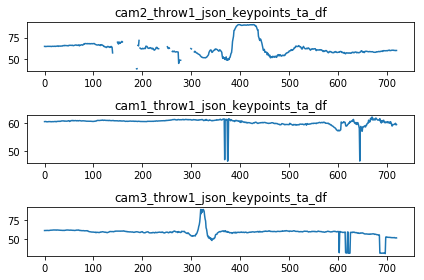

In [158]:
#scaled stacked axes graphics
ta_df_names_list= list( main_dict['ta'].keys() ) 
#print( ta_df_names_list)

#figure out how many subplots to make, as well as what the axes names should be
num_of_ta_dfs = len( ta_df_names_list )
#print( num_of_ta_dfs)

#set up the axes names
axes_list = []
for i in range(0, num_of_ta_dfs):
    axes_list.append('ax' + str(i) )
    #print( axes_list[i])

fig, (axes_list) = matplotlib.pyplot.subplots( num_of_ta_dfs )
print('Throwing Arm Elbow Angle for every video:\n x axis is frame number, y axis is the throwing arm angle')

    
#go through each dataframe, and plot the TA_elbow angle on its own subplot
for i in range( 0, num_of_ta_dfs):
    
    data_frame = main_dict['ta'][ta_df_names_list[i]]
    
    x = range( 0, data_frame.shape[0] )
    y = data_frame['TA_elbow_angle']
    
    axes_list[i].plot( x, y)
    axes_list[i].set_title( ta_df_names_list[i])

fig.tight_layout()


In [161]:
main_dict['ta']['cam3_throw1_json_keypoints_ta_df'][210:215]

,TA_elbow_angle,x5,y5,x6,y6,x7,y7,v5,v6,v7,a5,a6,a7
210,59.389167,832.648,519.911,908.175,522.653,991.777,547.833,0.023916,0.051102,1.652862,-559.034300,-898.580948,-159.665791
211,59.398469,829.914,519.919,905.233,522.598,986.298,545.071,1.683779,1.812188,3.778819,398.367095,422.660619,510.229605
212,59.171882,829.854,519.825,905.245,519.907,986.255,544.963,0.068679,1.657306,0.071591,-387.623893,-37.171660,-889.734640
213,58.446143,821.522,519.847,902.482,514.363,980.742,542.250,5.131395,3.814882,3.784108,1215.051730,517.818343,891.003897
214,58.094002,818.718,514.368,902.501,508.793,977.956,539.401,3.790533,3.430381,2.454091,-321.806820,-92.280287,-319.203916
